#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 08
**CH08B How is life expectancy related to the average income of a country?**

using the worldbank-lifeexpectancy dataset

version 1.0 2021-05-05

In [ ]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format
from plotnine import *
from datetime import datetime
from scipy.stats import norm
import statsmodels.formula.api as smf

warnings.filterwarnings("ignore")


Read clean data

In [ ]:
xc = pd.read_csv("/workspaces/codespaces-jupyter/data/worldbank-lifeexpectancy.csv")
#xc = pd.read_csv("https://osf.io/download/sh9mu/")
xc


,year,countryname,countrycode,lifeexp,population,gdppc
0,1990,Albania,ALB,71.836,3.286542,4.458248
1,1990,Algeria,DZA,66.725,25.758869,10.297842
2,1990,Angola,AGO,41.696,11.848386,4.761230
3,1990,Antigua and Barbuda,ATG,71.351,0.062528,17.472946
4,1990,Argentina,ARG,71.565,32.618651,11.372823
...,...,...,...,...,...,...
5024,2017,Vietnam,VNM,76.454,94.596642,6.233485
5025,2017,West Bank and Gaza,PSE,73.646,4.454805,4.651724
5026,2017,"Yemen, Rep.",YEM,65.157,27.834821,2.404422
5027,2017,Zambia,ZMB,62.255,16.853688,3.717667


select year

In [ ]:
xc["year"].unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017])

In [ ]:
xc = xc.loc[lambda x: x["year"] == 2008]

 GDP total, log

In [ ]:
xc["gdptot"] = xc["gdppc"] * xc["population"]
xc["lngdppc"] = np.log(xc["gdppc"])
xc["lngdptot"] = np.log(xc["gdptot"])

In [ ]:
xc.loc[:, ["lifeexp", "gdppc", "gdptot", "lngdppc", "lngdptot"]].describe()


,lifeexp,gdppc,gdptot,lngdppc,lngdptot
count,186.000000,186.000000,186.000000,186.000000,186.000000
mean,69.427877,17.968683,463.265147,2.235560,4.065231
std,9.012677,20.197819,1510.873803,1.241140,2.180454
min,46.190000,0.640080,0.180551,-0.446162,-1.711745
25%,63.613250,3.529174,14.987651,1.260984,2.707091
50%,72.126000,10.022357,50.564026,2.304815,3.923136
75%,75.640750,27.220446,307.227351,3.303686,5.727579
max,82.587561,115.779484,15311.044619,4.751687,9.636330


### Figure 8.3 The distribution of GDP per capita

(a) Histogram of GDP per capita

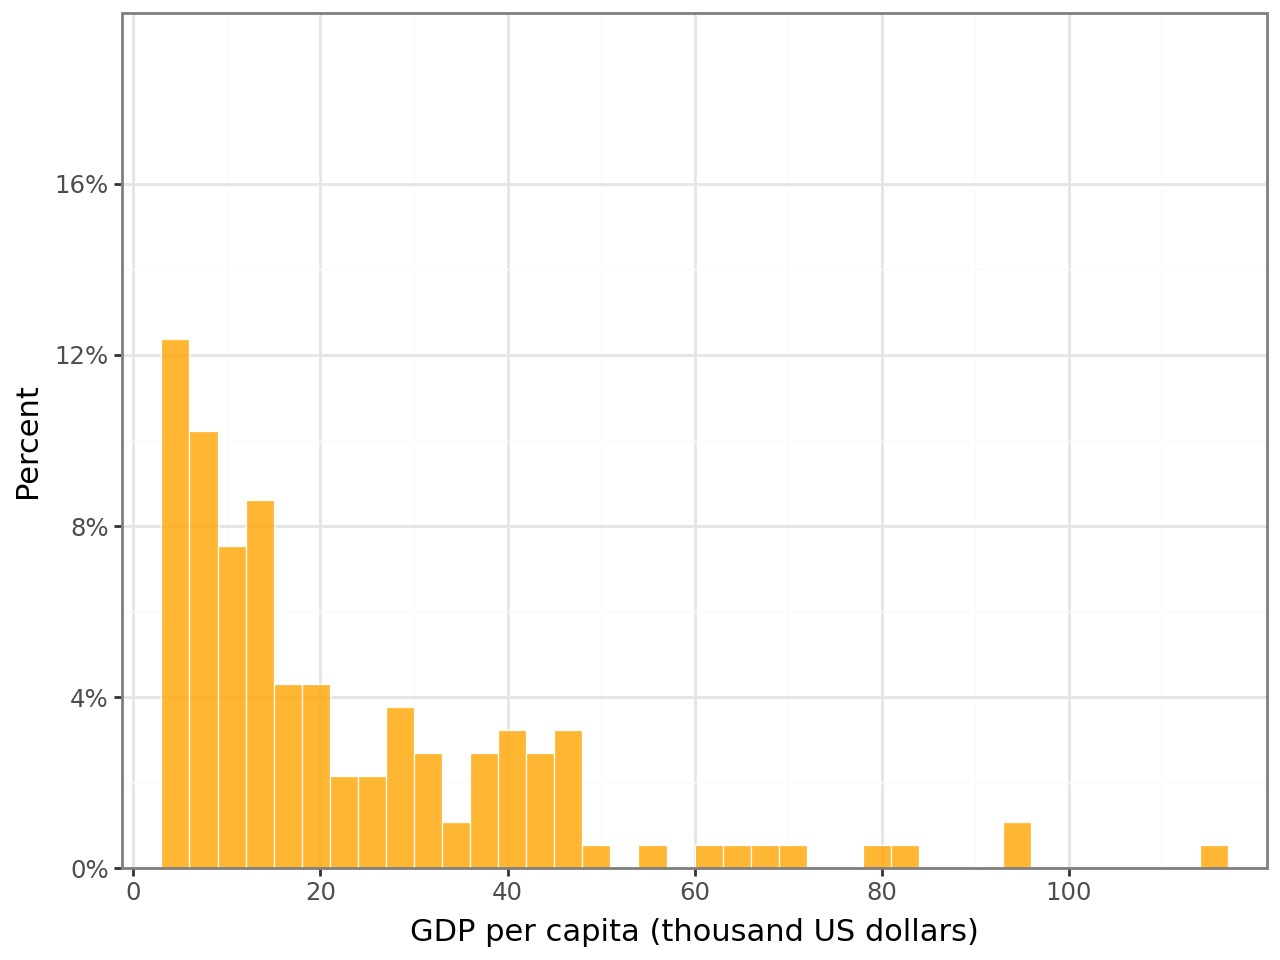

In [ ]:
(
    ggplot(xc, aes(x="gdppc", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=3,
        boundary=0,
        color="white",
        fill="orange",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="GDP per capita (thousand US dollars)", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 120), breaks=np.arange(0, 120, 20))
    + scale_y_continuous(
        labels=percent_format(),
        breaks=np.arange(0, 0.20, 0.04),
        limits=(0, 0.2),
        expand=(0.0, 0.0),
    )
    + theme_bw()
)


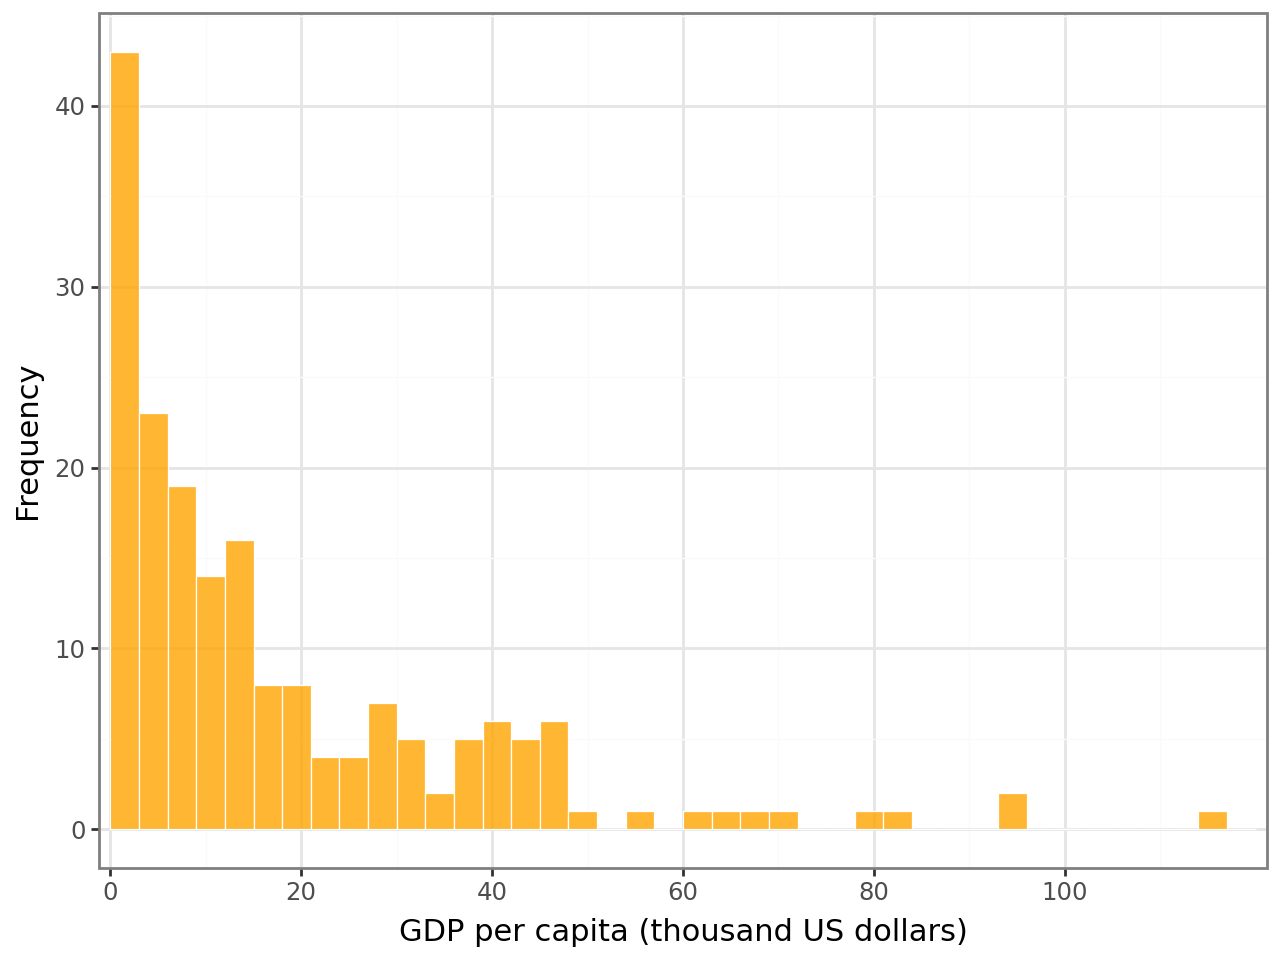

In [ ]:
(
    ggplot(xc, aes(x="gdppc"))
    + geom_histogram(
        binwidth=3,
        boundary=0,
        color="white",
        fill="orange",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="GDP per capita (thousand US dollars)", y="Frequency")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 120), breaks=np.arange(0, 120, 20))
    + theme_bw()
)


In [ ]:
xc.sort_values("gdppc", ascending=True).head()

,year,countryname,countrycode,lifeexp,population,gdppc,gdptot,lngdppc,lngdptot
3218,2008,"Congo, Dem. Rep.",COD,55.743,60.411195,0.640080,38.667986,-0.446162,3.655012
3207,2008,Burundi,BDI,53.926,8.126102,0.717793,5.832857,-0.331574,1.763507
3302,2008,Niger,NER,55.350,15.250908,0.815040,12.430106,-0.204518,2.520121
3295,2008,Mozambique,MOZ,53.459,22.276596,0.879475,19.591709,-0.128430,2.975106
3212,2008,Central African Republic,CAF,46.190,4.273366,0.887609,3.793076,-0.119224,1.333177


(b) Histogram of ln(GDP per capita)

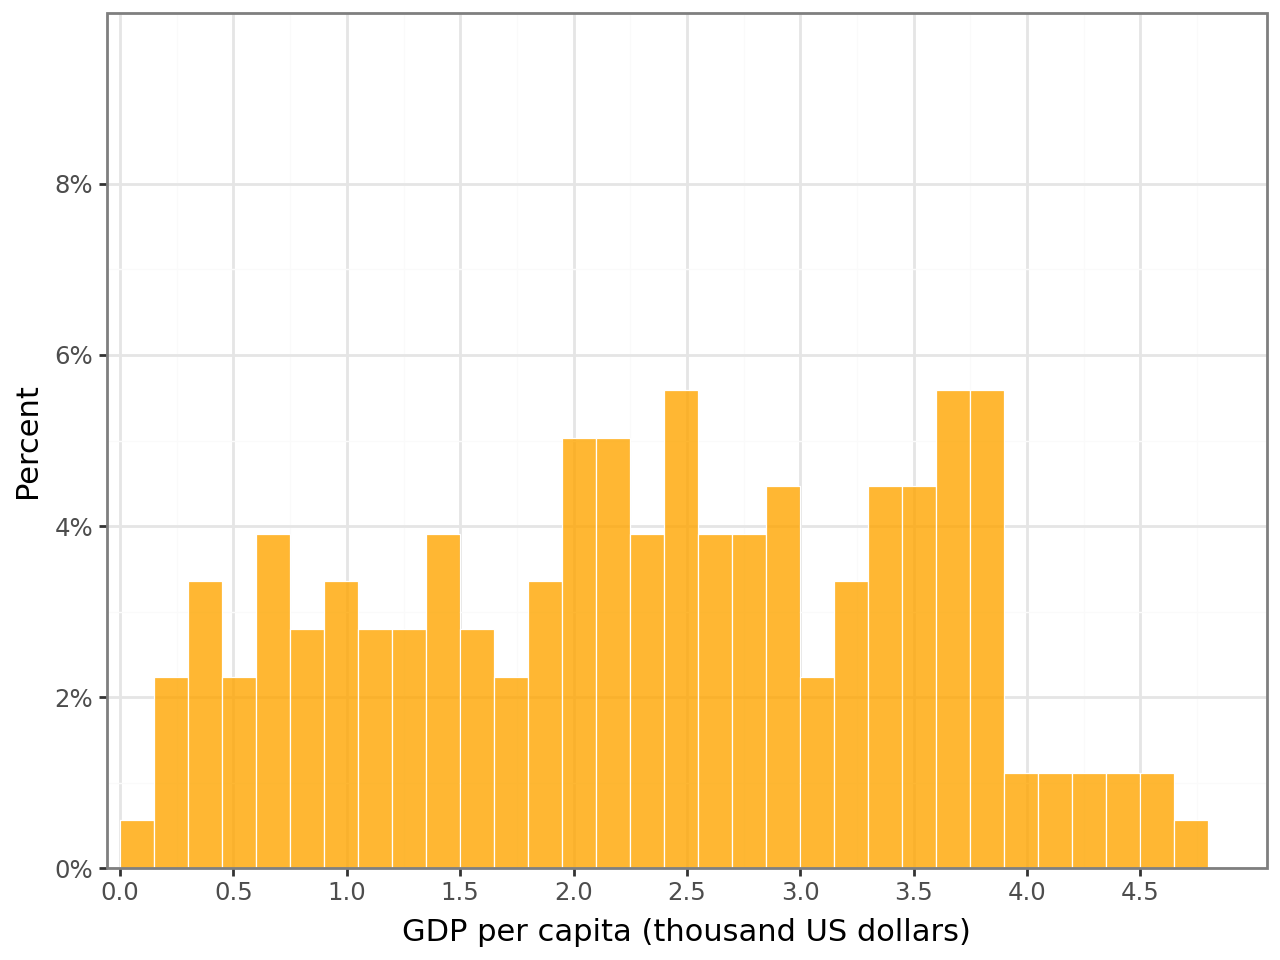

In [ ]:
(
    ggplot(xc, aes(x="lngdppc", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=0.15,
        boundary=0,
        color="white",
        fill="orange",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="GDP per capita (thousand US dollars)", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 5), breaks=np.arange(0, 5, 0.5))
    + scale_y_continuous(
        expand=(0.0, 0.0),
        limits=(0, 0.1),
        breaks=np.arange(0, 0.1, 0.02),
        labels=percent_format(),
    )
    + theme_bw()
)


 LEVEL-LEVEL REGRESSION

In [ ]:
reg3 = smf.ols(formula="lifeexp ~ gdppc", data=xc)
reg3.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     111.8
Date:                Wed, 02 Jul 2025   Prob (F-statistic):           1.01e-20
Time:                        19:52:28   Log-Likelihood:                -628.21
No. Observations:                 186   AIC:                             1260.
Df Residuals:                     184   BIC:                             1267.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     64.4983      0.700     92.099      0.000      63.117      65.880
gdppc          0.2743      0.026     10.574      0.000       0.223       0.326
==============================================================================
Omnibus:                       24.116   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.188
Skew:                          -0.985   Prob(JB):                     2.78e-07
Kurtosis:                       3.126   Cond. No.                         36.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Figure 8.4 Life expectancy and GDP per capita

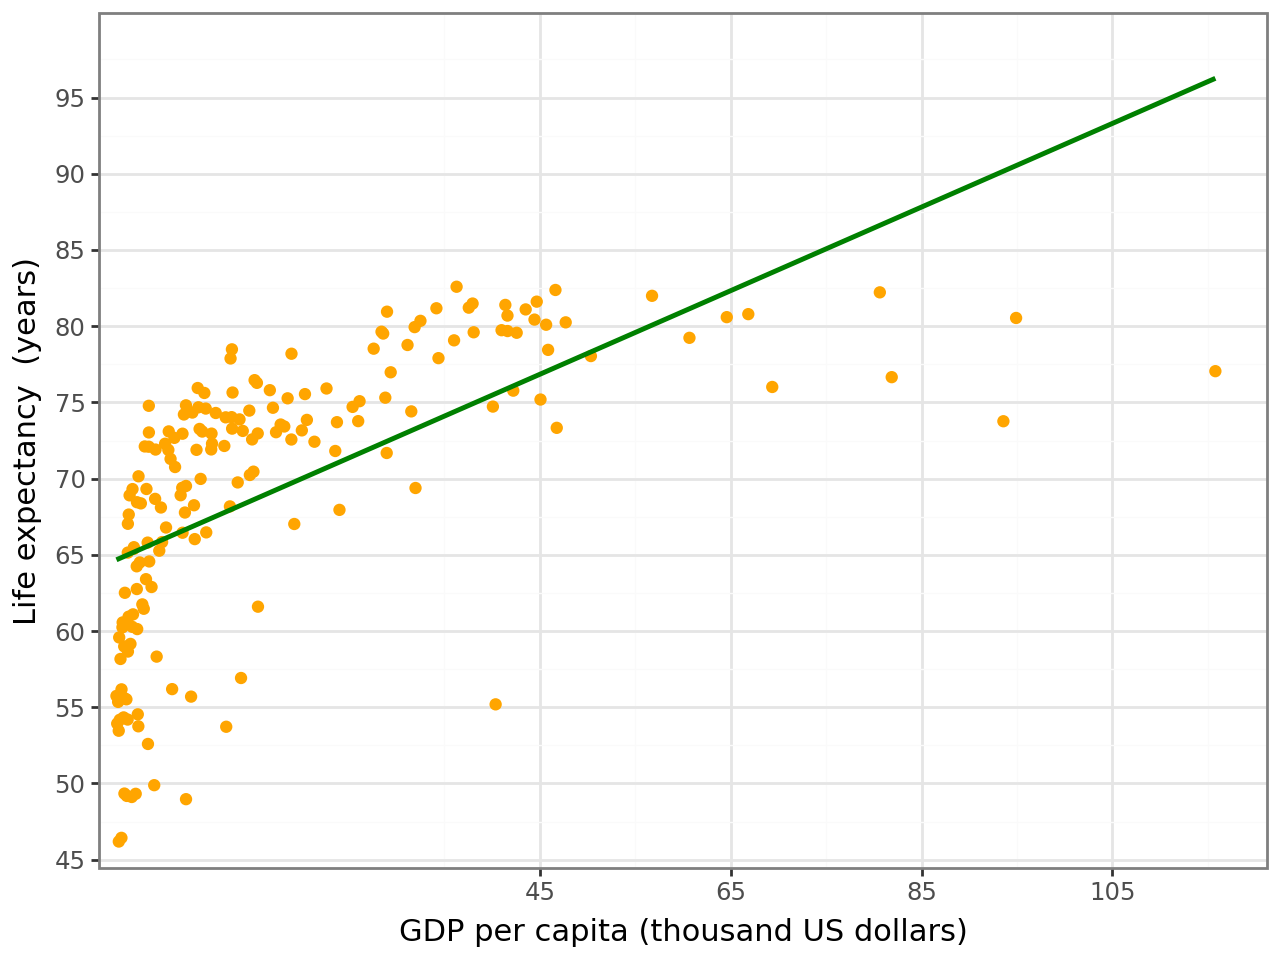

In [ ]:
(
    ggplot(xc, aes(x="gdppc", y="lifeexp"))
    + geom_point(color="orange")
    + geom_smooth(color="green", method="lm", se=False)
    + coord_cartesian(xlim=(0, 120), ylim=(45, 100))
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(0, 120), breaks=np.arange(45, 120, 20)
    )
    + scale_y_continuous(expand=(0.01, 0.01), breaks=np.arange(10, 100, 5))
    + labs(x="GDP per capita (thousand US dollars)", y="Life expectancy  (years)")
    + theme_bw()
)


LOG GDP PER CAPITA

In [ ]:
reg4 = smf.ols(formula="lifeexp ~ lngdppc", data=xc)
reg4.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     318.4
Date:                Wed, 02 Jul 2025   Prob (F-statistic):           5.42e-42
Time:                        19:52:29   Log-Likelihood:                -578.95
No. Observations:                 186   AIC:                             1162.
Df Residuals:                     184   BIC:                             1168.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     56.5044      0.828     68.253      0.000      54.871      58.138
lngdppc        5.7809      0.324     17.844      0.000       5.142       6.420
==============================================================================
Omnibus:                       51.566   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.153
Skew:                          -1.336   Prob(JB):                     2.95e-22
Kurtosis:                       5.378   Cond. No.                         5.91
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Figure 8.5 Life expectancy and GDP per capita

(a) Life expectancy and ln(GDP per capita)

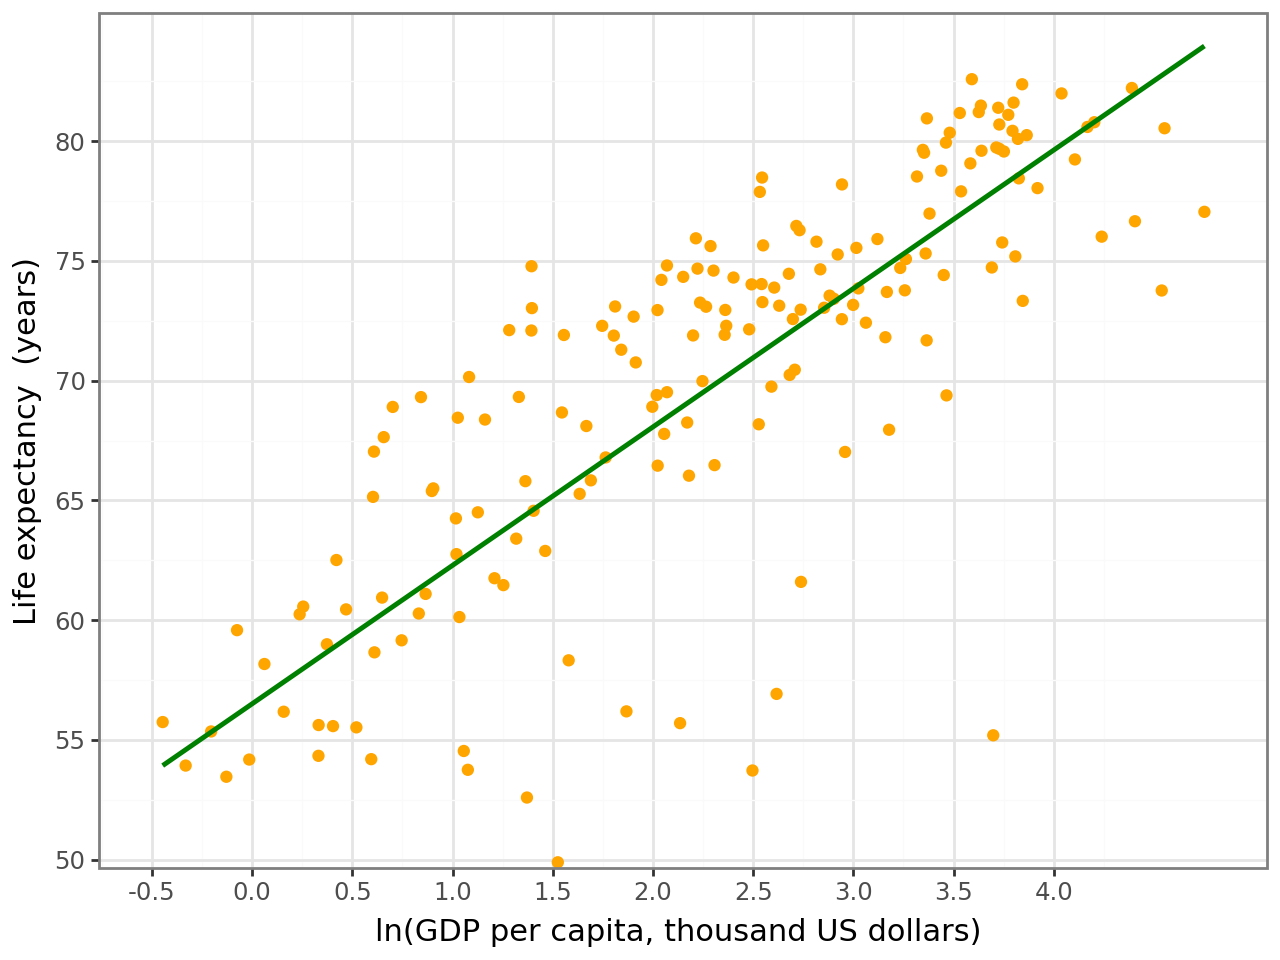

In [ ]:
(
    ggplot(xc, aes(x="lngdppc", y="lifeexp"))
    + geom_point(color="orange")
    + geom_smooth(color="green", method="lm", se=False)
    + coord_cartesian(xlim=(-0.5, 4.8), ylim=(50, 85))
    + scale_x_continuous(breaks=np.arange(-0.5, 4.5, 0.5))
    + scale_y_continuous(expand=(0.01, 0.01), breaks=np.arange(50, 85, 5))
    + labs(x="ln(GDP per capita, thousand US dollars) ", y="Life expectancy  (years)")
    + theme_bw()
)


(b) Life expectancy and ln(GDP per capita),
(labels are thousand dollars)

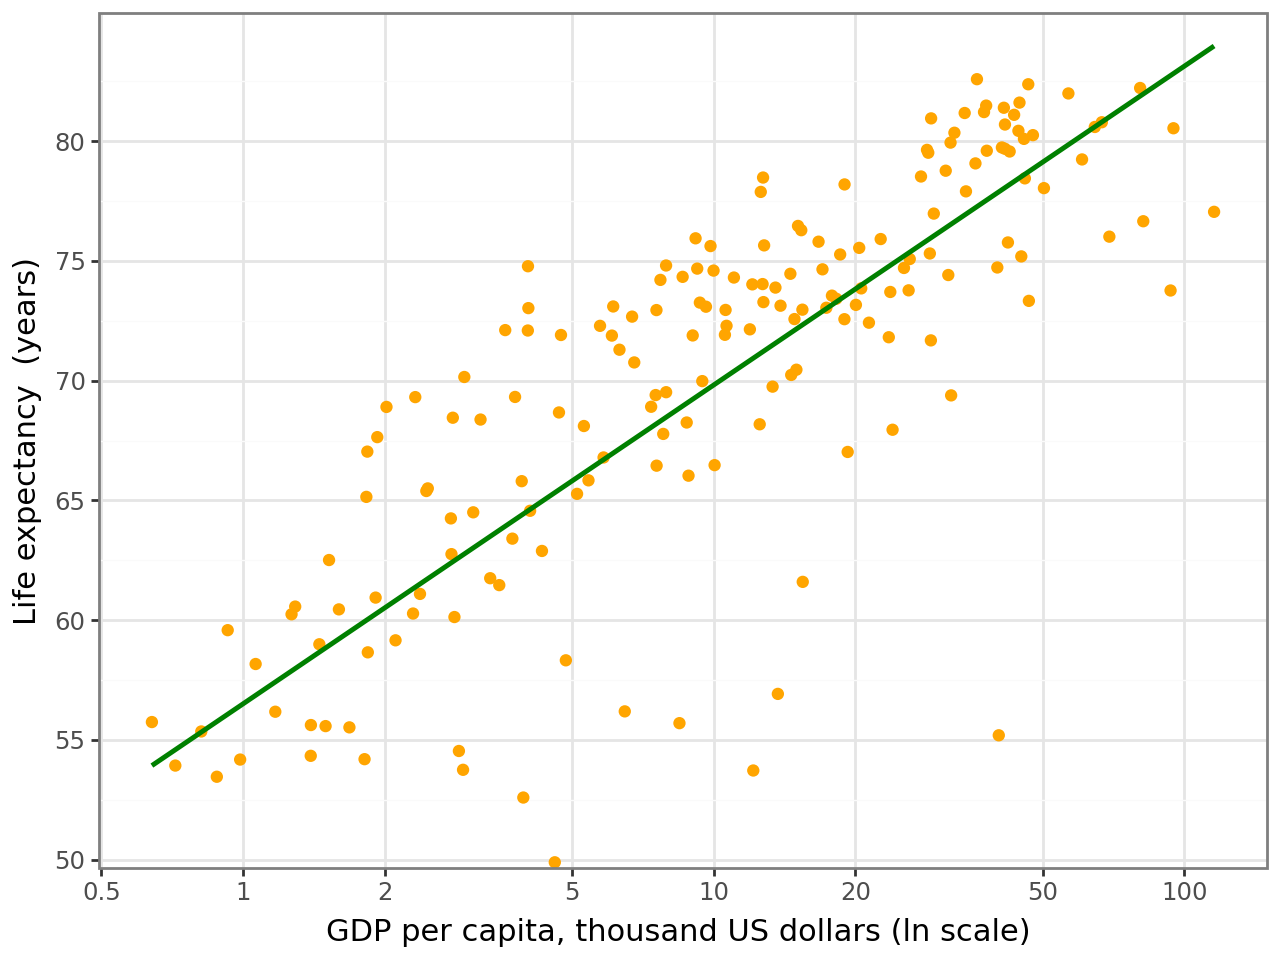

In [ ]:
(
    ggplot(xc, aes(x="gdppc", y="lifeexp"))
    + geom_point(color="orange")
    + geom_smooth(color="green", method="lm", se=False)
    + coord_cartesian(ylim=(50, 85))
    + scale_x_continuous(
        trans=log_trans(),
        breaks=(0.1, 0.5, 1, 2, 5, 10, 20, 50, 100),
        labels=log_format(),
    )
    + scale_y_continuous(expand=(0.01, 0.01), breaks=np.arange(50, 85,5))
    + labs(
        x="GDP per capita, thousand US dollars (ln scale) ",
        y="Life expectancy  (years)",
    )
    + theme_bw()
)

## LOWESS

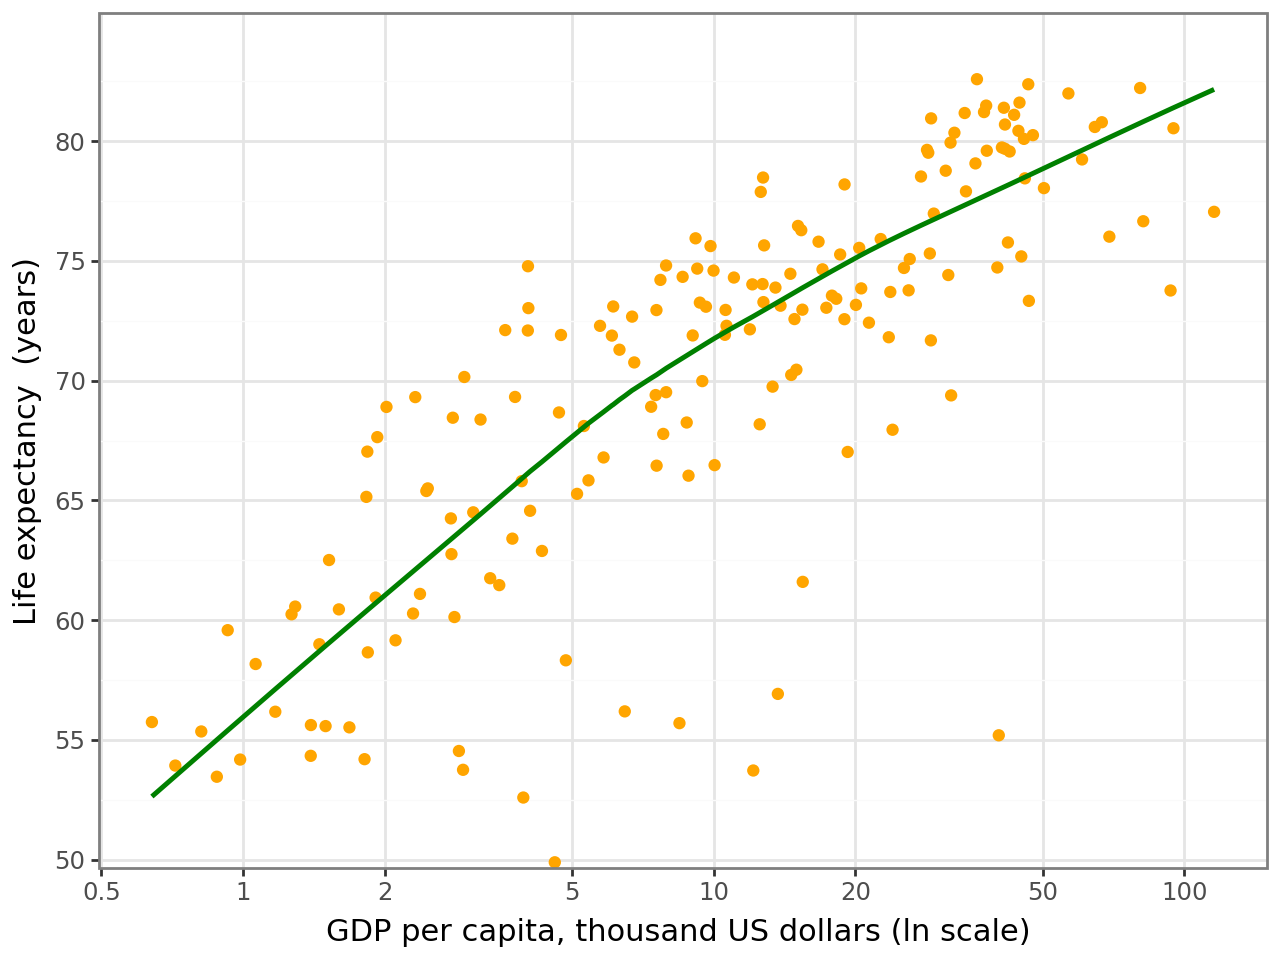

In [ ]:
(
    ggplot(xc, aes(x="gdppc", y="lifeexp"))
    + geom_point(color="orange")
    + geom_smooth(color="green", method="lowess", se=False)
    + coord_cartesian(ylim=(50, 85))
    + scale_x_continuous(
        trans=log_trans(),
        breaks=(0.1, 0.5, 1, 2, 5, 10, 20, 50, 100),
        labels=log_format(),
    )
    + scale_y_continuous(expand=(0.01, 0.01), breaks=np.arange(50, 85, 5))
    + labs(
        x="GDP per capita, thousand US dollars (ln scale) ",
        y="Life expectancy  (years)",
    )
    + theme_bw()
)

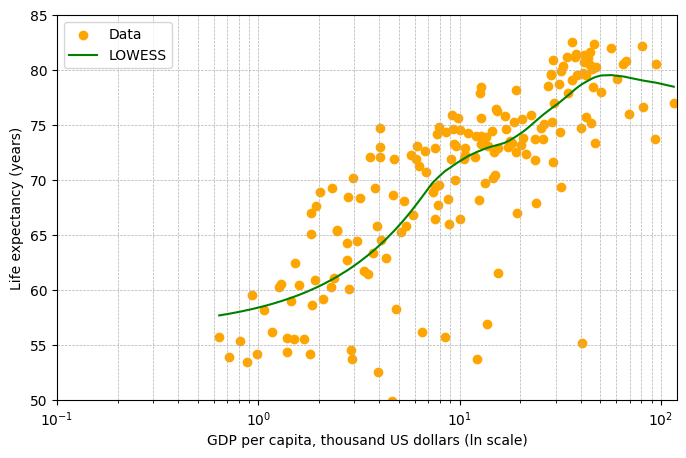

In [ ]:
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

import matplotlib.pyplot as plt

x = xc["gdppc"].values
y = xc["lifeexp"].values

# LOWESS smoothing
lowess_smoothed = lowess(y, x, frac=0.6)
x_lowess = lowess_smoothed[:, 0]
y_lowess = lowess_smoothed[:, 1]

plt.figure(figsize=(8, 5))
plt.scatter(x, y, color="orange", label="Data")
plt.plot(x_lowess, y_lowess, color="green", label="LOWESS")
plt.xscale("log")
plt.xlim(0.1, 120)
plt.ylim(50, 85)
plt.xlabel("GDP per capita, thousand US dollars (ln scale)")
plt.ylabel("Life expectancy (years)")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

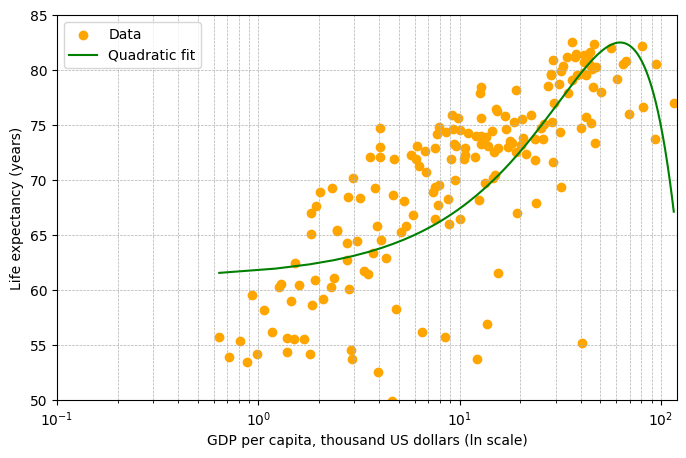

In [ ]:
# Fit a quadratic (2nd degree polynomial)
coeffs = np.polyfit(x, y, 2)
x_fit = np.linspace(x.min(), x.max(), 200)
y_fit = np.polyval(coeffs, x_fit)

plt.figure(figsize=(8, 5))
plt.scatter(x, y, color="orange", label="Data")
plt.plot(x_fit, y_fit, color="green", label="Quadratic fit")
plt.xscale("log")
plt.xlim(0.1, 120)
plt.ylim(50, 85)
plt.xlabel("GDP per capita, thousand US dollars (ln scale)")
plt.ylabel("Life expectancy (years)")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()


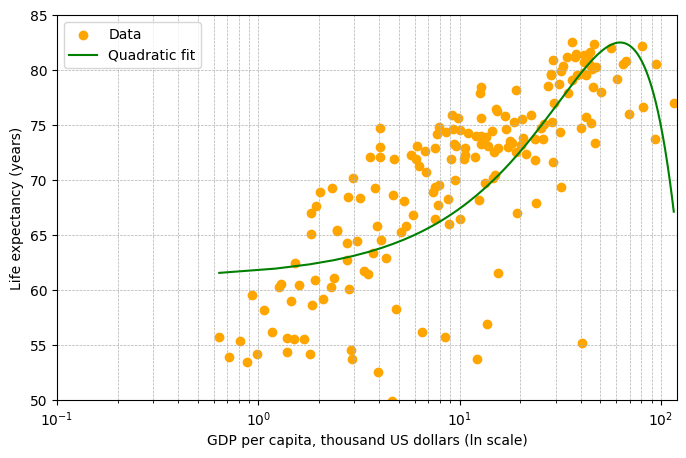

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(x, y, color="orange", label="Data")
plt.plot(x_fit, y_fit, color="green", label="Quadratic fit")
plt.xscale("log")
plt.xlim(0.1, 120)
plt.ylim(50, 85)
plt.xlabel("GDP per capita, thousand US dollars (ln scale)")
plt.ylabel("Life expectancy (years)")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()


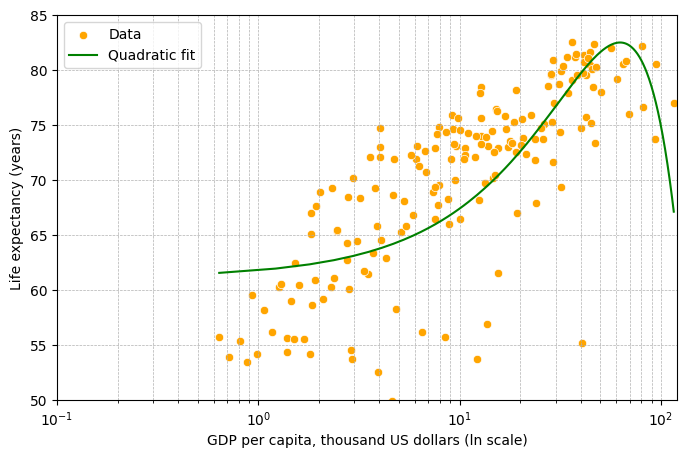

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.scatterplot(x=x, y=y, color="orange", label="Data")
sns.lineplot(x=x_fit, y=y_fit, color="green", label="Quadratic fit")
plt.xscale("log")
plt.xlim(0.1, 120)
plt.ylim(50, 85)
plt.xlabel("GDP per capita, thousand US dollars (ln scale)")
plt.ylabel("Life expectancy (years)")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()


### TOTAL GDP

Level-level regression

In [ ]:
reg1 = smf.ols(formula="lifeexp ~ gdppc", data=xc)
reg1.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     111.8
Date:                Wed, 02 Jul 2025   Prob (F-statistic):           1.01e-20
Time:                        19:52:32   Log-Likelihood:                -628.21
No. Observations:                 186   AIC:                             1260.
Df Residuals:                     184   BIC:                             1267.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     64.4983      0.700     92.099      0.000      63.117      65.880
gdppc          0.2743      0.026     10.574      0.000       0.223       0.326
==============================================================================
Omnibus:                       24.116   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.188
Skew:                          -0.985   Prob(JB):                     2.78e-07
Kurtosis:                       3.126   Cond. No.                         36.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Figure 8.6 Life expectancy and total GDP

(a) Life expectancy and total GDP

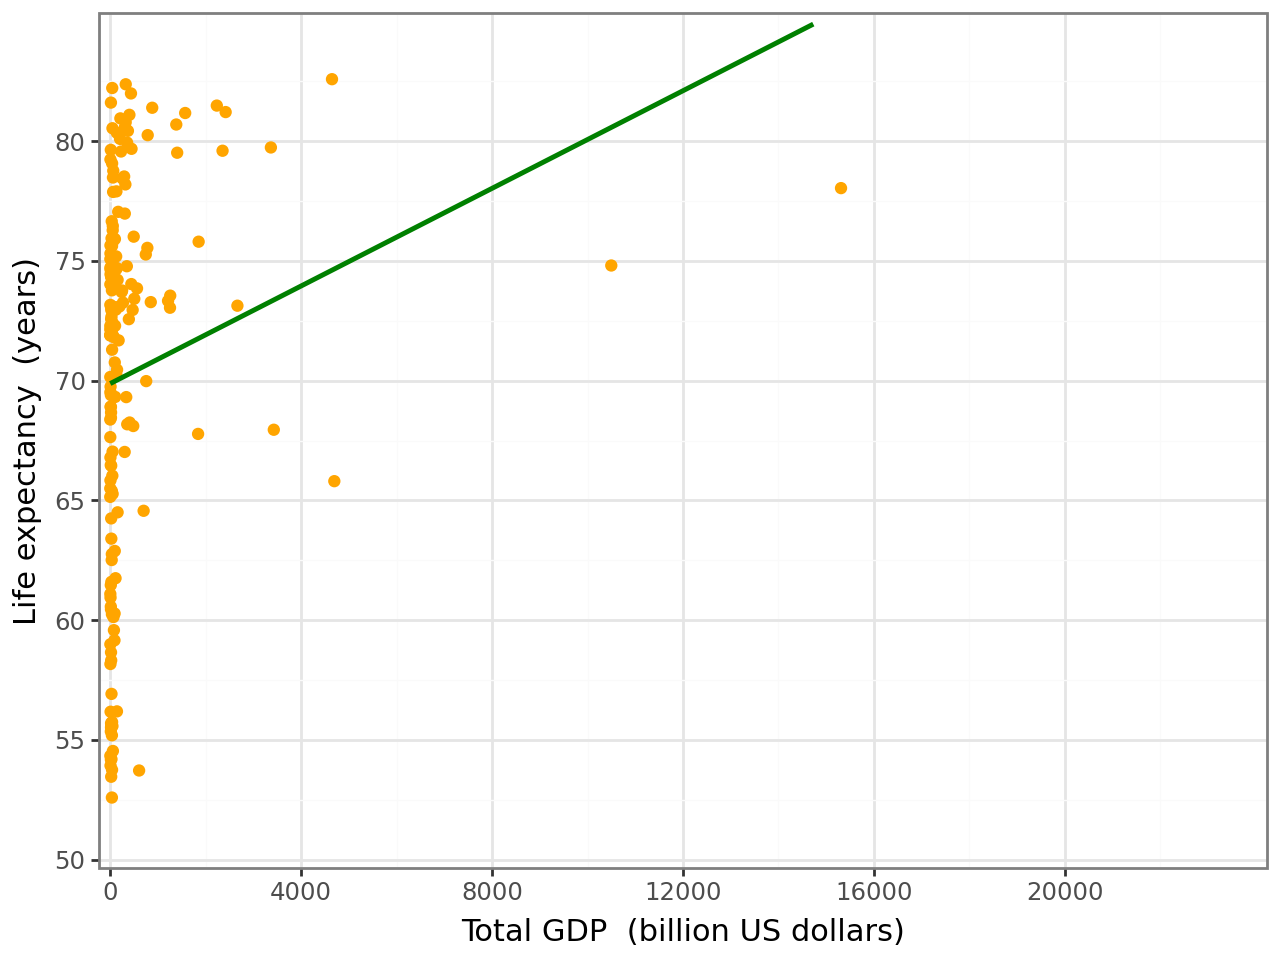

In [ ]:
(
    ggplot(xc, aes(x="gdptot", y="lifeexp"))
    + geom_point(color="orange")
    + geom_smooth(color="green", method="lm", se=False)
    + coord_cartesian(xlim=(0, 24000), ylim=(50, 85))
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(0, 24000), breaks=np.arange(0, 24000, 4000)
    )
    + scale_y_continuous(expand=(0.01, 0.01), limits=(50, 85), breaks=np.arange(50, 85, 5))
    + labs(x="Total GDP  (billion US dollars)", y="Life expectancy  (years)")
    + theme_bw()
)


(b) Life expectancy and ln total GDP

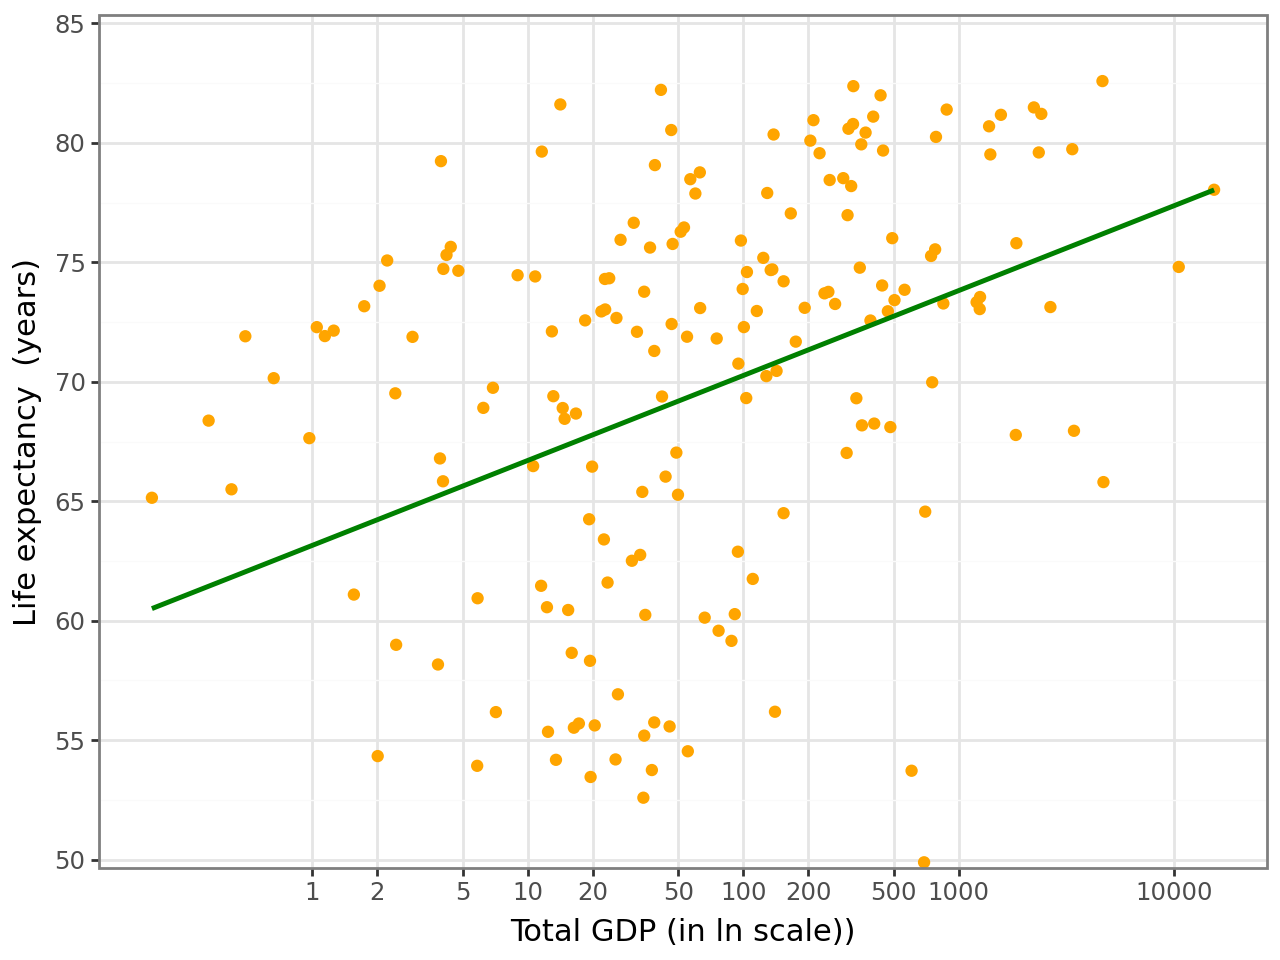

In [ ]:
(
    ggplot(xc, aes(x="gdptot", y="lifeexp"))
    + geom_point(color="orange")
    + geom_smooth(color="green", method="lm", se=False)
    + coord_cartesian(ylim=(50, 85))
    + scale_x_continuous(
        trans=log_trans(),
        breaks=(1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 10000),
        labels=log_format(),
    )
    + scale_y_continuous(expand=(0.01, 0.01), breaks=(50, 55, 60, 65, 70, 75, 80, 85))
    + labs(x="Total GDP (in ln scale))", y="Life expectancy  (years)")
    + theme_bw()
)

In [ ]:
reg15 = smf.ols(formula="lifeexp ~ gdptot", data=xc)
reg15.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     7.330
Date:                Wed, 02 Jul 2025   Prob (F-statistic):            0.00742
Time:                        19:52:33   Log-Likelihood:                -668.73
No. Observations:                 186   AIC:                             1341.
Df Residuals:                     184   BIC:                             1348.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     68.8870      0.680    101.329      0.000      67.546      70.228
gdptot         0.0012      0.000      2.707      0.007       0.000       0.002
==============================================================================
Omnibus:                       15.267   Durbin-Watson:                   1.742
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.159
Skew:                          -0.684   Prob(JB):                     0.000310
Kurtosis:                       2.540   Cond. No.                     1.65e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
reg2 = smf.ols(formula="lifeexp ~ lngdptot", data=xc)
reg2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     29.85
Date:                Wed, 02 Jul 2025   Prob (F-statistic):           1.50e-07
Time:                        19:52:33   Log-Likelihood:                -658.38
No. Observations:                 186   AIC:                             1321.
Df Residuals:                     184   BIC:                             1327.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     63.1500      1.303     48.461      0.000      60.579      65.721
lngdptot       1.5443      0.283      5.464      0.000       0.987       2.102
==============================================================================
Omnibus:                       14.688   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.093
Skew:                          -0.695   Prob(JB):                     0.000320
Kurtosis:                       2.620   Cond. No.                         10.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
xc["gdptot"].describe()

count      186.000000
mean       463.265147
std       1510.873803
min          0.180551
25%         14.987651
50%         50.564026
75%        307.227351
max      15311.044619
Name: gdptot, dtype: float64

### GDP PER CAPITA PIECEWISE LINEAR SPLINE


In [ ]:
xc

,year,countryname,countrycode,lifeexp,population,gdppc,gdptot,lngdppc,lngdptot
3179,2008,Afghanistan,AFG,60.243,27.722276,1.267645,35.142003,0.237161,3.559397
3180,2008,Albania,ALB,75.943,2.947314,9.154715,26.981819,2.214269,3.295163
3181,2008,Algeria,DZA,74.032,34.730608,12.707831,441.350709,2.542218,6.089840
3182,2008,Angola,AGO,56.189,21.695634,6.474376,140.465701,1.867852,4.944963
3183,2008,Antigua and Barbuda,ATG,75.078,0.085397,26.110659,2.229772,3.262344,0.801899
...,...,...,...,...,...,...,...,...,...
3360,2008,Vietnam,VNM,74.777,86.243413,4.031551,347.694755,1.394151,5.851325
3361,2008,West Bank and Gaza,PSE,72.110,3.591977,3.606900,12.955901,1.282849,2.561551
3362,2008,"Yemen, Rep.",YEM,62.888,21.892146,4.317230,94.513440,1.462614,4.548742
3363,2008,Zambia,ZMB,53.749,12.848530,2.934293,37.701352,1.076467,3.629696


In [ ]:
cutoff = 50
cutoff_ln = np.log(cutoff)

In [ ]:
# Create spline variables
xc["lngdppc_spline"] = np.where(xc["lngdppc"] > cutoff_ln, xc["lngdppc"] - cutoff_ln, 0)

# Run the regression
reg5 = smf.ols(formula="lifeexp ~ lngdppc + lngdppc_spline", data=xc)
reg5.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     165.5
Date:                Wed, 02 Jul 2025   Prob (F-statistic):           9.27e-42
Time:                        19:52:33   Log-Likelihood:                -576.34
No. Observations:                 186   AIC:                             1159.
Df Residuals:                     183   BIC:                             1168.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         56.0423      0.843     66.469      0.000      54.379      57.706
lngdppc            6.0803      0.346     17.569      0.000       5.398       6.763
lngdppc_spline    -9.0184      3.946     -2.285      0.023     -16.805      -1.232
==============================================================================
Omnibus:                       57.822   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.522
Skew:                          -1.417   Prob(JB):                     2.04e-28
Kurtosis:                       5.903   Cond. No.                         27.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
xc["e3"] = reg5.fit().resid
xc["sppred"] = reg5.fit().predict()


### Figure 8.7 Life expectancy and GDP per capita: scatterplot and nonlinear regression

(a) Piecewise linear spline

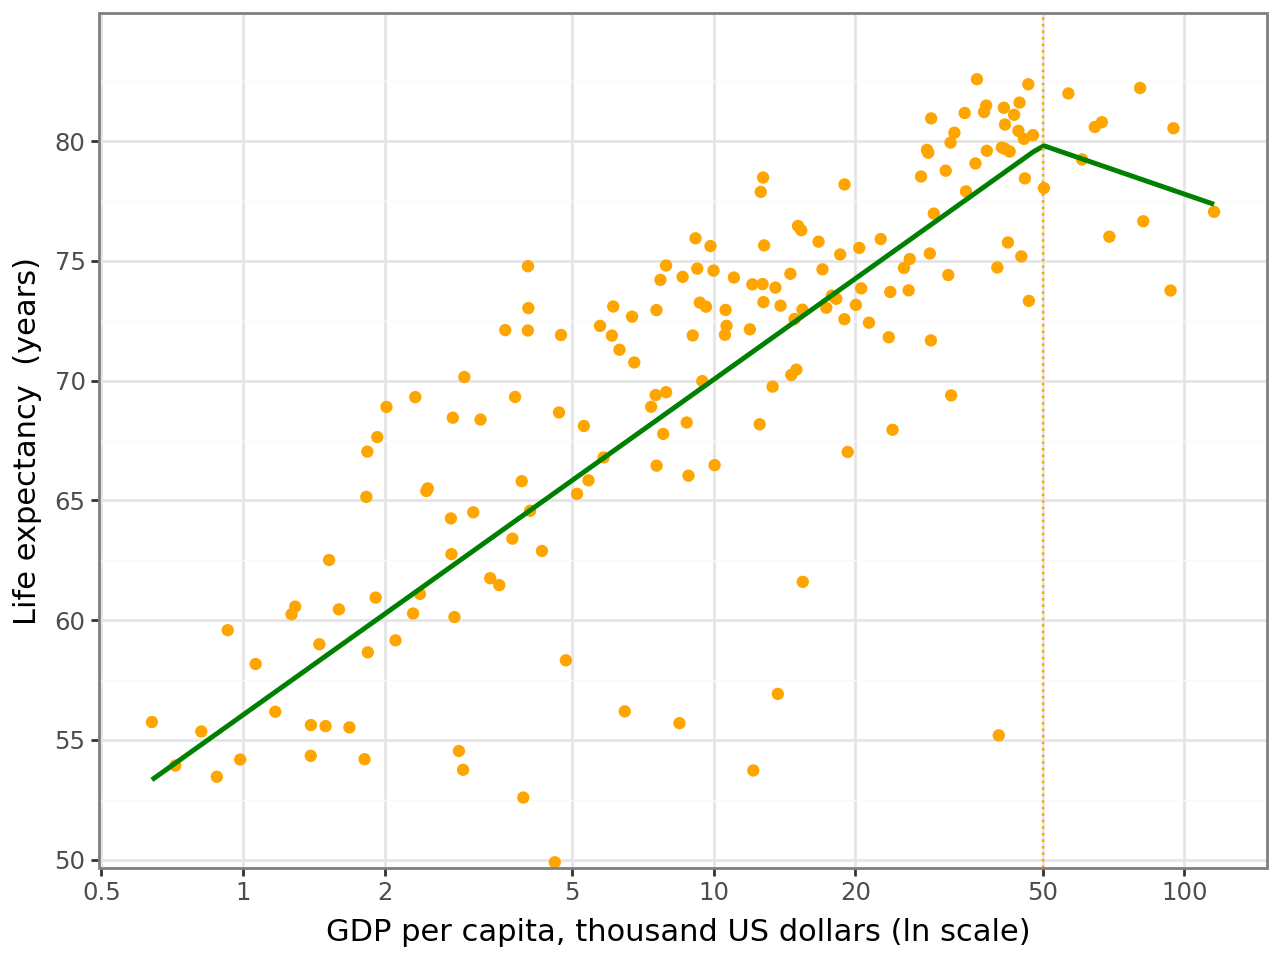

In [ ]:
(
    ggplot(xc, aes(x="gdppc", y="lifeexp"))
    + geom_point(color="orange")
    + geom_line(xc, aes(x="gdppc", y="sppred"), color="green", size=1)
    + geom_vline(xintercept=cutoff, color="orange", size=0.5, linetype="dotted")
    + coord_cartesian(ylim=(50, 85))
    + scale_x_continuous(
        trans=log_trans(),
        breaks=(0.1, 0.5, 1, 2, 5, 10, 20, 50, 100),
        labels=log_format(),
    )
    + scale_y_continuous(expand=(0.01, 0.01), breaks=np.arange(50, 85, 5))
    + labs(
        x="GDP per capita, thousand US dollars (ln scale) ",
        y="Life expectancy  (years)",
    )
    + theme_bw()
)

### QUADRATIC IN LEVEL-LOG REGRESSION

In [ ]:
xc["lngdppc_sq"] = xc["lngdppc"].pow(2)
reg6 = smf.ols(formula="lifeexp ~ lngdppc+lngdppc_sq", data=xc)
reg6.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     164.7
Date:                Wed, 02 Jul 2025   Prob (F-statistic):           1.22e-41
Time:                        19:52:33   Log-Likelihood:                -576.61
No. Observations:                 186   AIC:                             1159.
Df Residuals:                     183   BIC:                             1169.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     54.8758      1.114     49.266      0.000      52.678      57.073
lngdppc        8.1085      1.125      7.210      0.000       5.890      10.327
lngdppc_sq    -0.5475      0.254     -2.160      0.032      -1.048      -0.047
==============================================================================
Omnibus:                       59.696   Durbin-Watson:                   2.142
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.359
Skew:                          -1.474   Prob(JB):                     4.93e-29
Kurtosis:                       5.852   Cond. No.                         34.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
xc["e6"] = reg6.fit().resid
xc["e6"] 

3179     3.474975
3180     5.797092
3181     2.080913
3182   -11.922181
3183    -0.423777
          ...    
3360     9.660853
3361     7.733225
3362    -2.676201
3363    -9.220906
3364    -8.608262
Name: e6, Length: 186, dtype: float64

(b) Quadratic function

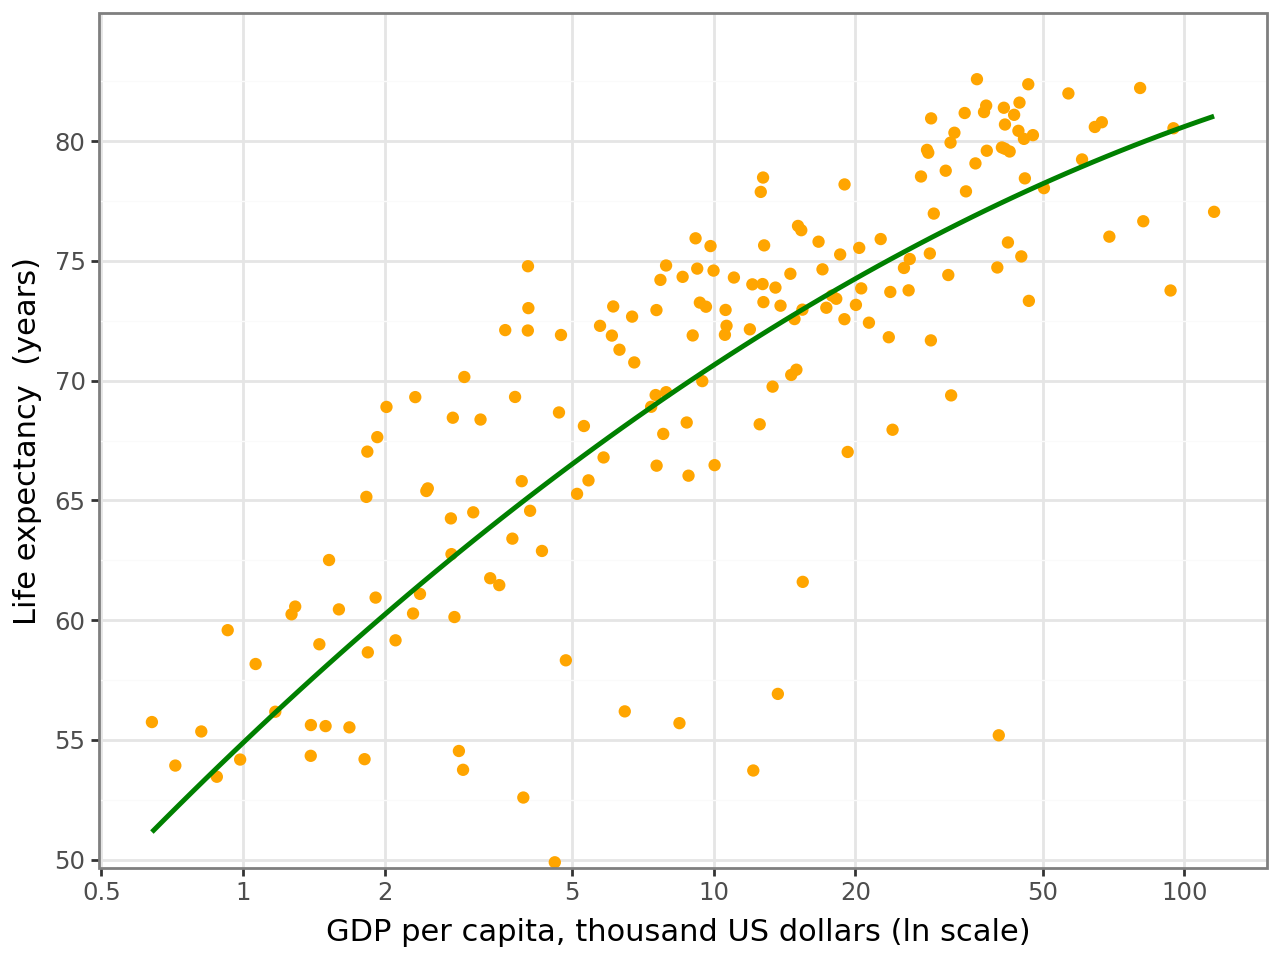

In [ ]:
(
    ggplot(xc, aes(x="gdppc", y="lifeexp"))
    + geom_point(color="orange")
    + geom_smooth(
        method="lm",
        formula="y ~ x + I(x**2)",
        color="green",
        se=False,
        size=1
    )
    + coord_cartesian(ylim=(50, 85))
    + scale_x_continuous(
        trans=log_trans(),
        breaks=(0.1, 0.5, 1, 2, 5, 10, 20, 50, 100),
        labels=log_format(),
    )
    + scale_y_continuous(expand=(0.01, 0.01), breaks=np.arange(50, 85, 5))
    + labs(
        x="GDP per capita, thousand US dollars (ln scale) ",
        y="Life expectancy  (years)",
    )
    + theme_bw()
)

### WEIGHTED AND UNWEIGHTED REGRESSION

In [ ]:
reg7 = smf.ols(formula="lifeexp ~ lngdppc", data=xc)
reg7.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     318.4
Date:                Wed, 02 Jul 2025   Prob (F-statistic):           5.42e-42
Time:                        19:52:34   Log-Likelihood:                -578.95
No. Observations:                 186   AIC:                             1162.
Df Residuals:                     184   BIC:                             1168.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     56.5044      0.828     68.253      0.000      54.871      58.138
lngdppc        5.7809      0.324     17.844      0.000       5.142       6.420
==============================================================================
Omnibus:                       51.566   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.153
Skew:                          -1.336   Prob(JB):                     2.95e-22
Kurtosis:                       5.378   Cond. No.                         5.91
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
reg7 = smf.wls(formula="lifeexp ~ lngdppc", data=xc, weights=xc.population)
reg7.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.581
Model:                            WLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     254.9
Date:                Wed, 02 Jul 2025   Prob (F-statistic):           1.42e-36
Time:                        19:52:34   Log-Likelihood:                -720.10
No. Observations:                 186   AIC:                             1444.
Df Residuals:                     184   BIC:                             1451.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     58.2017      0.825     70.581      0.000      56.575      59.829
lngdppc        5.7373      0.359     15.965      0.000       5.028       6.446
==============================================================================
Omnibus:                      101.105   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4041.738
Skew:                          -1.267   Prob(JB):                         0.00
Kurtosis:                      25.696   Cond. No.                         6.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Figure 8.9 Life expectancy and log GDP per capita: unweighted and weighted regressions

(a) Unweighted

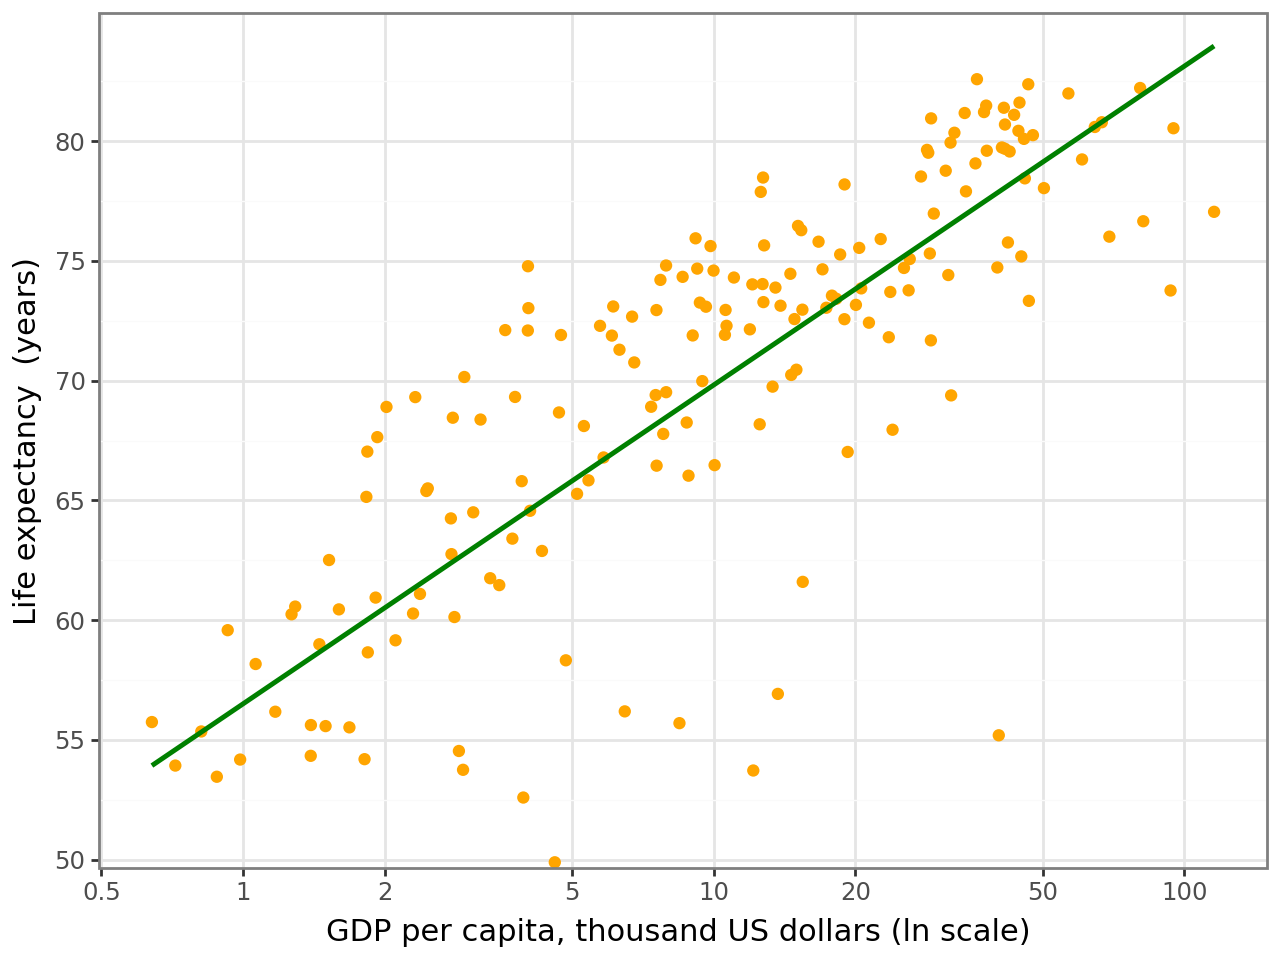

In [ ]:
(
    ggplot(xc, aes(x="gdppc", y="lifeexp"))
    + geom_point(color="orange")
    + stat_smooth(color="green", method="lm", se=False, size=1)
    + coord_cartesian(ylim=(50, 85))
    + scale_x_continuous(
        trans=log_trans(),
        breaks=(0.1, 0.5, 1, 2, 5, 10, 20, 50, 100),
        labels=log_format(),
    )
    + scale_y_continuous(expand=(0.01, 0.01), breaks=np.arange(50, 85, 5))
    + labs(
        x="GDP per capita, thousand US dollars (ln scale) ",
        y="Life expectancy  (years)",
    )
    + theme_bw()
)

(b) Weighted

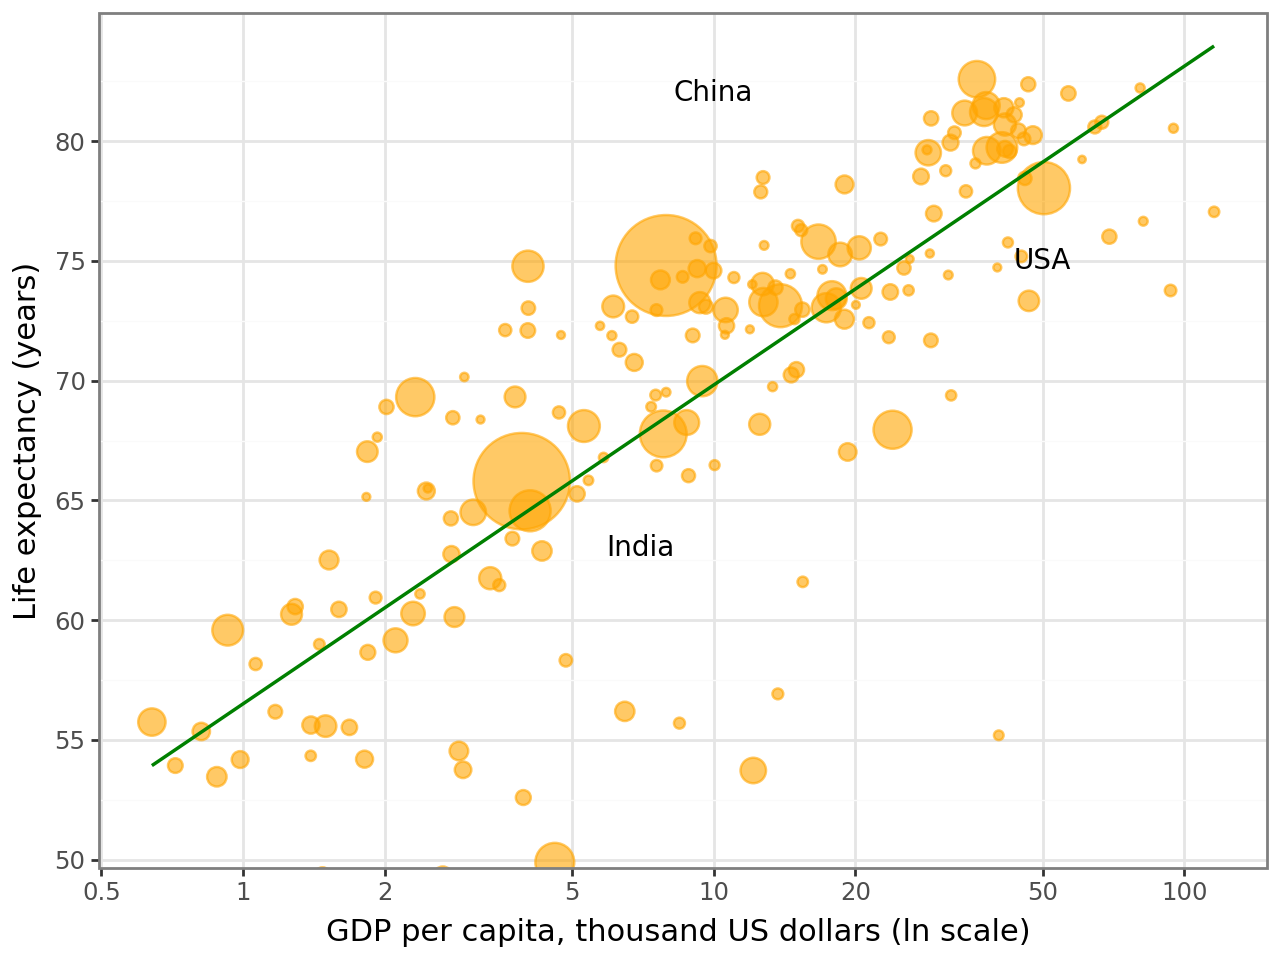

In [ ]:
# alpha does not work, if I set color="orange"
(
    ggplot(xc, aes(x="gdppc", y="lifeexp"))
    + geom_point(
        xc, aes(size="population"), color="orange", alpha=0.6, show_legend=False
    )
    + scale_fill_identity()
    + scale_color_identity()
    + geom_smooth(
        aes(weight="population"), method="lm", color="green", se=False, size=0.7
    )
    + scale_size(range=(1, 20))
    + coord_cartesian(ylim=(50, 85))
    + scale_x_continuous(
        trans=log_trans(),
        breaks=(0.1, 0.5, 1, 2, 5, 10, 20, 50, 100),
        labels=log_format(),
    )
    + scale_y_continuous(expand=(0.01, 0.01), breaks=np.arange(50, 85, 5))
    + labs(
        x="GDP per capita, thousand US dollars (ln scale) ", y="Life expectancy (years)"
    )
    + theme_bw()
    + annotate("text", x=50, y=75, label="USA", size=10)
    + annotate("text", x=10, y=82, label="China", size=10)
    + annotate("text", x=7, y=63, label="India", size=10)
)

In [ ]:
xc.sort_values("population", ascending=False).head()

,year,countryname,countrycode,lifeexp,population,gdppc,gdptot,lngdppc,lngdptot,lngdppc_spline,e3,sppred,lngdppc_sq,e6
3215,2008,China,CHN,74.808000,1324.655000,7.924644,10497.419781,2.069977,9.258885,0.00000,6.179468,68.628532,4.284807,5.493642
3255,2008,India,IND,65.802000,1200.669765,3.910055,4694.684545,1.363551,8.454186,0.00000,1.468784,64.333216,1.859272,0.887773
3355,2008,United States,USA,78.039024,304.093966,50.349715,15311.044619,3.918993,9.636330,0.00697,-1.769309,79.808333,15.358506,-0.205522
3256,2008,Indonesia,IDN,67.775000,235.469762,7.815449,1840.301843,2.056102,7.517685,0.00000,-0.769167,68.544167,4.227557,-1.458195
3203,2008,Brazil,BRA,73.129000,192.030362,13.874211,2664.269728,2.630032,7.887685,0.00000,1.095142,72.033858,6.917067,0.714538


# GDP & Business

In [ ]:
GDP_data = pd.read_csv("/workspaces/codespaces-jupyter/data/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_5826.csv", skiprows=4)
business = pd.read_csv("/workspaces/codespaces-jupyter/data/Starting a Business.csv")

In [ ]:
GDP_data = GDP_data[["Country Name", "Country Code", "Indicator Name", "Indicator Code", "2019"]]
GDP_data

,Country Name,Country Code,Indicator Name,Indicator Code,2019
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,31096.205074
1,Africa Eastern and Southern,AFE,GDP per capita (current US$),NY.GDP.PCAP.CD,1493.817938
2,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,496.602504
3,Africa Western and Central,AFW,GDP per capita (current US$),NY.GDP.PCAP.CD,1798.340685
4,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,2189.855714
...,...,...,...,...,...
261,Kosovo,XKX,GDP per capita (current US$),NY.GDP.PCAP.CD,4415.997161
262,"Yemen, Rep.",YEM,GDP per capita (current US$),NY.GDP.PCAP.CD,623.376168
263,South Africa,ZAF,GDP per capita (current US$),NY.GDP.PCAP.CD,6533.711210
264,Zambia,ZMB,GDP per capita (current US$),NY.GDP.PCAP.CD,1258.986198


In [ ]:
business["Time – All (days)"] = (business["Time – Men (days)"]+ business["Time – Women (days)"])/2
business

,Unnamed: 0,Location,Starting a Business score,Procedure – Men (number),Time – Men (days),Cost – Men (% of income per capita),Procedure – Women (number),Time – Women (days),Cost – Women (% of income per capita),Paid-in min. capital (% of income per capita),Starting a Business rank,Time – All (days)
0,NaN,Afghanistan,92.0,4,8.0,6.8,5,9.0,6.8,0.0,52,8.5
1,NaN,Albania,91.8,5,4.5,10.8,5,4.5,10.8,0.0,53,4.5
2,NaN,Algeria,78.0,12,18.0,11.3,12,18.0,11.3,0.0,152,18.0
3,NaN,Angola,79.4,8,36.0,11.1,8,36.0,11.1,0.0,146,36.0
4,NaN,Antigua and Barbuda,82.6,9,19.0,8.0,9,19.0,8.0,0.0,130,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...
208,NaN,Vietnam,85.1,8,16.0,5.6,8,16.0,5.6,0.0,115,16.0
209,NaN,West Bank and Gaza,70.2,10,43.0,40.3,11,44.0,40.3,0.0,173,43.5
210,NaN,"Yemen, Rep.",76.8,6,40.0,40.2,7,41.0,40.2,0.0,156,40.5
211,NaN,Zambia,84.9,7,8.5,34.0,7,8.5,34.0,0.0,117,8.5


In [ ]:
missing_countries = set(business["Location"]) - set(GDP_data["Country Name"])
print(missing_countries)

{'China - Shanghai', 'Taiwan, China', 'Bangladesh - Chittagong', 'Brazil - Rio de Janeiro', 'India - Delhi', 'Mexico - Monterrey', 'Mexico - Mexico City', 'United States - Los Angeles', 'Nigeria - Kano', 'Brazil - São Paulo', 'Turkey', 'Nigeria - Lagos', 'Pakistan - Karachi', "Côte d'Ivoire", 'Japan - Tokyo', 'São Tomé and Príncipe', 'Czech Republic', 'Russian Federation - Moscow', 'Russian Federation - Saint Petersburg', 'Japan - Osaka', 'Puerto Rico', 'Bangladesh - Dhaka', 'Liechtenstein*', 'Indonesia - Jakarta', 'Indonesia - Surabaya', 'Vietnam', 'Pakistan - Lahore', 'United States - New York City', 'India - Mumbai', 'China - Beijing'}


In [ ]:
data = pd.merge(GDP_data, business, left_on="Country Name", right_on="Location")
data

,Country Name,Country Code,Indicator Name,Indicator Code,2019,Unnamed: 0,Location,Starting a Business score,Procedure – Men (number),Time – Men (days),Cost – Men (% of income per capita),Procedure – Women (number),Time – Women (days),Cost – Women (% of income per capita),Paid-in min. capital (% of income per capita),Starting a Business rank,Time – All (days)
0,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,496.602504,NaN,Afghanistan,92.0,4,8.0,6.8,5,9.0,6.8,0.0,52,8.5
1,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,2189.855714,NaN,Angola,79.4,8,36.0,11.1,8,36.0,11.1,0.0,146,36.0
2,Albania,ALB,GDP per capita (current US$),NY.GDP.PCAP.CD,5460.430509,NaN,Albania,91.8,5,4.5,10.8,5,4.5,10.8,0.0,53,4.5
3,United Arab Emirates,ARE,GDP per capita (current US$),NY.GDP.PCAP.CD,44251.454140,NaN,United Arab Emirates,94.8,2,3.5,17.2,3,4.5,17.2,0.0,17,4.0
4,Argentina,ARG,GDP per capita (current US$),NY.GDP.PCAP.CD,9955.974787,NaN,Argentina,80.4,12,11.5,5.0,12,11.5,5.0,0.0,141,11.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,Kosovo,XKX,GDP per capita (current US$),NY.GDP.PCAP.CD,4415.997161,NaN,Kosovo,95.9,3,4.5,1.4,3,4.5,1.4,0.0,12,4.5
179,"Yemen, Rep.",YEM,GDP per capita (current US$),NY.GDP.PCAP.CD,623.376168,NaN,"Yemen, Rep.",76.8,6,40.0,40.2,7,41.0,40.2,0.0,156,40.5
180,South Africa,ZAF,GDP per capita (current US$),NY.GDP.PCAP.CD,6533.711210,NaN,South Africa,81.2,7,40.0,0.2,7,40.0,0.2,0.0,139,40.0
181,Zambia,ZMB,GDP per capita (current US$),NY.GDP.PCAP.CD,1258.986198,NaN,Zambia,84.9,7,8.5,34.0,7,8.5,34.0,0.0,117,8.5


In [ ]:
data=data[data["2019"].notna()]
data

,Country Name,Country Code,Indicator Name,Indicator Code,2019,Unnamed: 0,Location,Starting a Business score,Procedure – Men (number),Time – Men (days),Cost – Men (% of income per capita),Procedure – Women (number),Time – Women (days),Cost – Women (% of income per capita),Paid-in min. capital (% of income per capita),Starting a Business rank,Time – All (days)
0,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,496.602504,NaN,Afghanistan,92.0,4,8.0,6.8,5,9.0,6.8,0.0,52,8.5
1,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,2189.855714,NaN,Angola,79.4,8,36.0,11.1,8,36.0,11.1,0.0,146,36.0
2,Albania,ALB,GDP per capita (current US$),NY.GDP.PCAP.CD,5460.430509,NaN,Albania,91.8,5,4.5,10.8,5,4.5,10.8,0.0,53,4.5
3,United Arab Emirates,ARE,GDP per capita (current US$),NY.GDP.PCAP.CD,44251.454140,NaN,United Arab Emirates,94.8,2,3.5,17.2,3,4.5,17.2,0.0,17,4.0
4,Argentina,ARG,GDP per capita (current US$),NY.GDP.PCAP.CD,9955.974787,NaN,Argentina,80.4,12,11.5,5.0,12,11.5,5.0,0.0,141,11.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,Kosovo,XKX,GDP per capita (current US$),NY.GDP.PCAP.CD,4415.997161,NaN,Kosovo,95.9,3,4.5,1.4,3,4.5,1.4,0.0,12,4.5
179,"Yemen, Rep.",YEM,GDP per capita (current US$),NY.GDP.PCAP.CD,623.376168,NaN,"Yemen, Rep.",76.8,6,40.0,40.2,7,41.0,40.2,0.0,156,40.5
180,South Africa,ZAF,GDP per capita (current US$),NY.GDP.PCAP.CD,6533.711210,NaN,South Africa,81.2,7,40.0,0.2,7,40.0,0.2,0.0,139,40.0
181,Zambia,ZMB,GDP per capita (current US$),NY.GDP.PCAP.CD,1258.986198,NaN,Zambia,84.9,7,8.5,34.0,7,8.5,34.0,0.0,117,8.5


In [ ]:
#stats 
#xc.loc[:, ["lifeexp", "gdppc", "gdptot", "lngdppc", "lngdptot"]].describe()
data = data.rename(columns={"2019": "gdppc"})
data = data.rename(columns={"Time – All (days)": "time_to_start_business"})
data.describe()

,gdppc,Unnamed: 0,Starting a Business score,Procedure – Men (number),Time – Men (days),Cost – Men (% of income per capita),Procedure – Women (number),Time – Women (days),Cost – Women (% of income per capita),Paid-in min. capital (% of income per capita),time_to_start_business
count,180.000000,0.0,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,14735.317195,NaN,84.881111,6.461111,18.252778,19.073333,6.577778,18.369444,19.075556,4.041111,18.311111
std,19865.195131,NaN,10.270693,2.736805,20.436610,31.163260,2.750227,20.447805,31.163285,11.059715,20.441575
min,210.236495,NaN,36.400000,1.000000,0.500000,0.000000,1.000000,0.500000,0.000000,0.000000,0.500000
25%,2107.706386,NaN,80.325000,4.000000,7.000000,2.050000,4.000000,7.000000,2.050000,0.000000,7.000000
50%,6036.602007,NaN,87.000000,6.000000,12.000000,7.950000,6.000000,12.000000,7.950000,0.000000,12.000000
75%,18957.657106,NaN,92.325000,8.000000,20.625000,22.450000,8.000000,20.625000,22.450000,1.100000,20.625000
max,112696.649060,NaN,100.000000,16.000000,173.000000,198.200000,16.000000,173.000000,198.200000,88.300000,173.000000


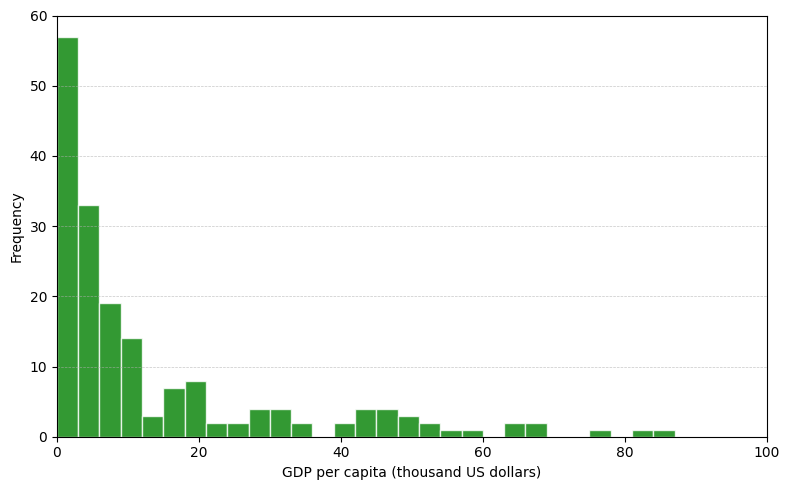

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(data["gdppc"] / 1000, bins=range(0, 123, 3), color="green", edgecolor="white", alpha=0.8)
plt.xlabel("GDP per capita (thousand US dollars)")
plt.ylabel("Frequency")
plt.xlim(0, 100)
plt.ylim(0, 60)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


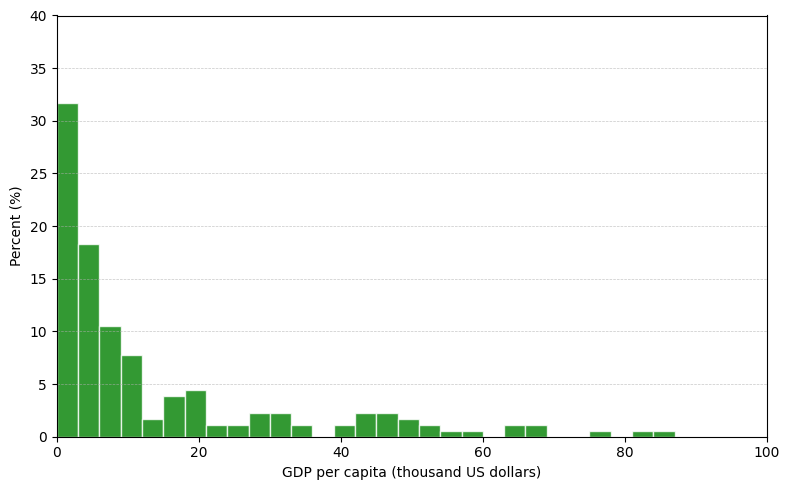

In [ ]:
plt.figure(figsize=(8, 5))
counts, bins, patches = plt.hist(data["gdppc"] / 1000, bins=range(0, 123, 3), color="green", edgecolor="white", alpha=0.8)
percent = counts / counts.sum() * 100
plt.clf()  # Clear the current plot

plt.bar(bins[:-1], percent, width=3, color="green", edgecolor="white", alpha=0.8, align='edge')
plt.xlabel("GDP per capita (thousand US dollars)")
plt.ylabel("Percent (%)")
plt.xlim(0, 100)
plt.ylim(0, 40)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
data["lngdppc"] = np.log(data["gdppc"])
data["lngdppc"].describe()

count    180.000000
mean       8.716993
std        1.419785
min        5.348233
25%        7.653188
50%        8.705496
75%        9.849948
max       11.632455
Name: lngdppc, dtype: float64

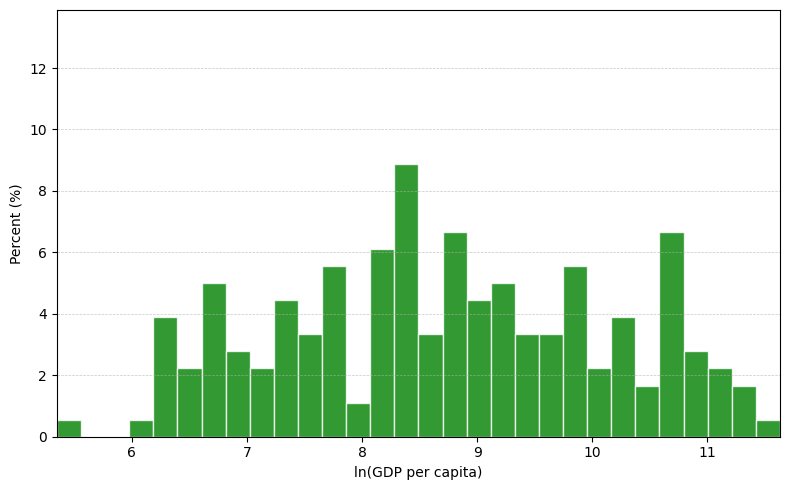

In [ ]:
plt.figure(figsize=(8, 5))
counts, bins, patches = plt.hist(data["lngdppc"], bins=30, color="green", edgecolor="white", alpha=0.8)
percent = counts / counts.sum() * 100
plt.clf()  # Clear the current plot

plt.bar(bins[:-1], percent, width=(bins[1] - bins[0]), color="green", edgecolor="white", alpha=0.8, align='edge')
plt.xlabel("ln(GDP per capita)")
plt.ylabel("Percent (%)")
plt.xlim(data["lngdppc"].min(), data["lngdppc"].max())
plt.ylim(0, percent.max() + 5)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# Level-Level Regression

data_lr = smf.ols(formula="time_to_start_business ~ gdppc", data=data)
data_lr.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     time_to_start_business   R-squared:                       0.063
Model:                                OLS   Adj. R-squared:                  0.058
Method:                     Least Squares   F-statistic:                     12.05
Date:                    Wed, 02 Jul 2025   Prob (F-statistic):           0.000649
Time:                            19:52:35   Log-Likelihood:                -792.17
No. Observations:                     180   AIC:                             1588.
Df Residuals:                         178   BIC:                             1595.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.1297      1.843     12.008      0.000      18.493      25.766
gdppc         -0.0003   7.46e-05     -3.472      0.001      -0.000      -0.000
==============================================================================
Omnibus:                      173.438   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3474.856
Skew:                           3.633   Prob(JB):                         0.00
Kurtosis:                      23.261   Cond. No.                     3.08e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
data[["time_to_start_business", "gdppc"]]

,time_to_start_business,gdppc
0,8.5,496.602504
1,36.0,2189.855714
2,4.5,5460.430509
3,4.0,44251.454140
4,11.5,9955.974787
...,...,...
178,4.5,4415.997161
179,40.5,623.376168
180,40.0,6533.711210
181,8.5,1258.986198


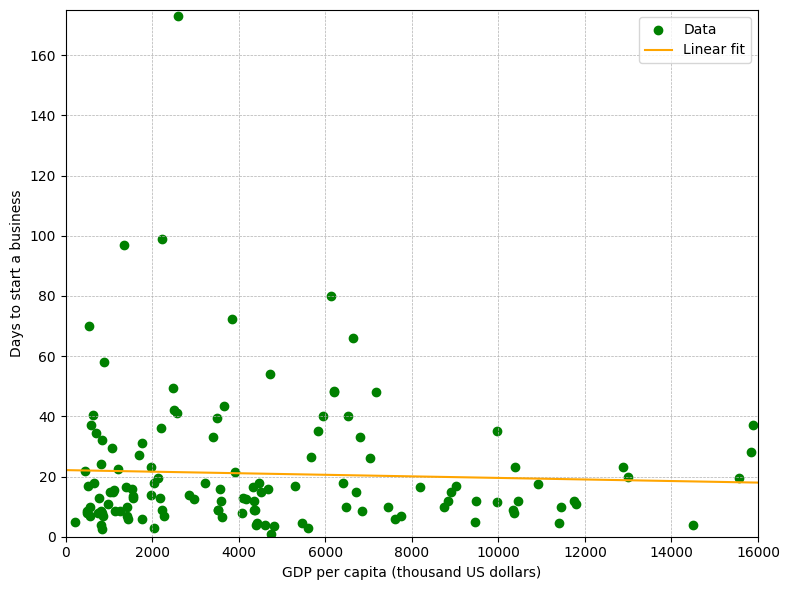

In [ ]:
%matplotlib inline

plt.figure(figsize=(8, 6))
plt.scatter(data["gdppc"], data["time_to_start_business"], color="green", label="Data")
coeffs = np.polyfit(data["gdppc"], data["time_to_start_business"], 1)
x_vals = np.linspace(0, 16000, 1000)
y_vals = np.polyval(coeffs, x_vals)
plt.plot(x_vals, y_vals, color="orange", label="Linear fit")
plt.xlim(0, 16000)
plt.ylim(0, data["time_to_start_business"].max() + 2)
plt.xlabel("GDP per capita (thousand US dollars)")
plt.ylabel("Days to start a business")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()


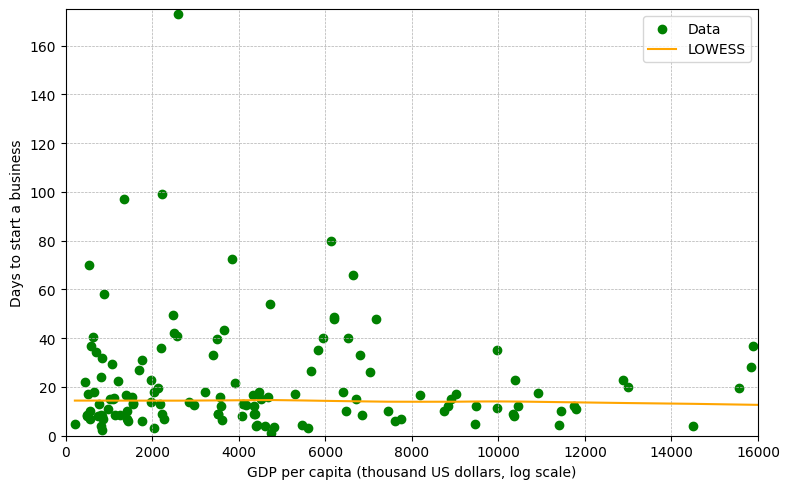

In [ ]:
x = data["gdppc"]  # Convert to thousands
y = data["time_to_start_business"]

lowess_smoothed = lowess(y, x, frac=0.6)
x_lowess = lowess_smoothed[:, 0]
y_lowess = lowess_smoothed[:, 1]

plt.figure(figsize=(8, 5))
plt.scatter(x, y, color="green", label="Data")
plt.plot(x_lowess, y_lowess, color="orange", label="LOWESS")
plt.xlim(0, 16000)  # Show the full range up to 16,000 (thousand USD)
plt.ylim(0, data["time_to_start_business"].max() + 2)
plt.xlabel("GDP per capita (thousand US dollars, log scale)")
plt.ylabel("Days to start a business")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()


In [ ]:
data_lr_ln = smf.ols(formula="time_to_start_business ~ lngdppc", data=data)
data_lr_ln.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     time_to_start_business   R-squared:                       0.057
Model:                                OLS   Adj. R-squared:                  0.051
Method:                     Least Squares   F-statistic:                     10.70
Date:                    Wed, 02 Jul 2025   Prob (F-statistic):            0.00128
Time:                            19:52:36   Log-Likelihood:                -792.82
No. Observations:                     180   AIC:                             1590.
Df Residuals:                         178   BIC:                             1596.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     48.2006      9.256      5.207      0.000      29.935      66.466
lngdppc       -3.4289      1.048     -3.272      0.001      -5.497      -1.361
==============================================================================
Omnibus:                      171.968   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3396.447
Skew:                           3.591   Prob(JB):                         0.00
Kurtosis:                      23.032   Cond. No.                         55.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

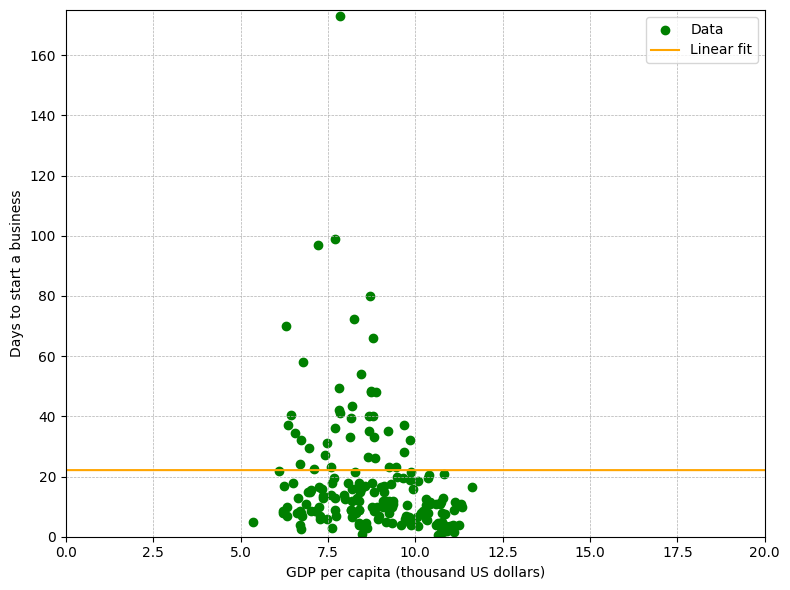

In [ ]:
%matplotlib inline

plt.figure(figsize=(8, 6))
plt.scatter(data["lngdppc"], data["time_to_start_business"], color="green", label="Data")
coeffs = np.polyfit(data["gdppc"], data["time_to_start_business"], 1)
x_vals = np.linspace(0, 20, 5)
y_vals = np.polyval(coeffs, x_vals)
plt.plot(x_vals, y_vals, color="orange", label="Linear fit")
plt.xlim(0, 20)
plt.ylim(0, data["time_to_start_business"].max() + 2)
plt.xlabel("GDP per capita (thousand US dollars)")
plt.ylabel("Days to start a business")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()


In [ ]:
data["lntime"] = np.log(data["time_to_start_business"])

data_ln_ln = smf.ols(formula="lntime ~ lngdppc", data=data)
data_ln_ln.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lntime   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     19.38
Date:                Wed, 02 Jul 2025   Prob (F-statistic):           1.85e-05
Time:                        19:52:36   Log-Likelihood:                -228.46
No. Observations:                 180   AIC:                             460.9
Df Residuals:                     178   BIC:                             467.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2494      0.403     10.557      0.000       3.455       5.044
lngdppc       -0.2006      0.046     -4.402      0.000      -0.291      -0.111
==============================================================================
Omnibus:                        1.789   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.409   Jarque-Bera (JB):                1.409
Skew:                          -0.128   Prob(JB):                        0.494
Kurtosis:                       3.350   Cond. No.                         55.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

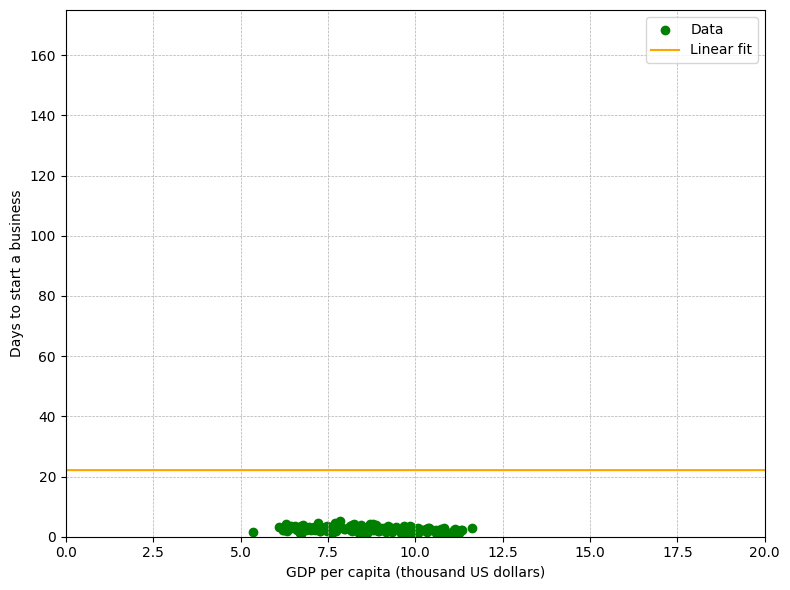

In [ ]:
%matplotlib inline

plt.figure(figsize=(8, 6))
plt.scatter(data["lngdppc"], data["lntime"], color="green", label="Data")
coeffs = np.polyfit(data["gdppc"], data["time_to_start_business"], 1)
x_vals = np.linspace(0, 20, 5)
y_vals = np.polyval(coeffs, x_vals)
plt.plot(x_vals, y_vals, color="orange", label="Linear fit")
plt.xlim(0, 20)
plt.ylim(0, data["time_to_start_business"].max() + 2)
plt.xlabel("GDP per capita (thousand US dollars)")
plt.ylabel("Days to start a business")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()


In [ ]:
data["gdppc_sq"] = data["gdppc"].pow(2)
data_sq = smf.ols(formula="time_to_start_business ~ gdppc+gdppc_sq", data=data)
data_sq.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     time_to_start_business   R-squared:                       0.083
Model:                                OLS   Adj. R-squared:                  0.073
Method:                     Least Squares   F-statistic:                     8.049
Date:                    Wed, 02 Jul 2025   Prob (F-statistic):           0.000451
Time:                            19:52:36   Log-Likelihood:                -790.24
No. Observations:                     180   AIC:                             1586.
Df Residuals:                         177   BIC:                             1596.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.2553      2.125     11.414      0.000      20.062      28.449
gdppc         -0.0006      0.000     -3.152      0.002      -0.001      -0.000
gdppc_sq    4.996e-09   2.55e-09      1.963      0.051   -2.74e-11       1e-08
==============================================================================
Omnibus:                      172.573   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3497.022
Skew:                           3.597   Prob(JB):                         0.00
Kurtosis:                      23.359   Cond. No.                     2.35e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.35e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
data["gdppc_cub"] = data["gdppc"].pow(3)
data_cub = smf.ols(formula="time_to_start_business ~ gdppc+gdppc_cub", data=data)
data_cub.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     time_to_start_business   R-squared:                       0.082
Model:                                OLS   Adj. R-squared:                  0.071
Method:                     Least Squares   F-statistic:                     7.867
Date:                    Wed, 02 Jul 2025   Prob (F-statistic):           0.000533
Time:                            19:52:36   Log-Likelihood:                -790.41
No. Observations:                     180   AIC:                             1587.
Df Residuals:                         177   BIC:                             1596.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.5380      1.978     11.898      0.000      19.634      27.442
gdppc         -0.0004      0.000     -3.628      0.000      -0.001      -0.000
gdppc_cub   3.325e-14   1.77e-14      1.874      0.063   -1.77e-15    6.83e-14
==============================================================================
Omnibus:                      173.327   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3539.420
Skew:                           3.619   Prob(JB):                         0.00
Kurtosis:                      23.483   Cond. No.                     1.88e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.88e+14. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
xc[xc["countryname"].str.contains("Russian", case=False, na=False)]


,year,countryname,countrycode,lifeexp,population,gdppc,gdptot,lngdppc,lngdptot,lngdppc_spline,e3,sppred,lngdppc_sq,e6
3318,2008,Russian Federation,RUS,67.949268,142.74235,24.005997,3426.67238,3.178304,8.139345,0.0,-7.418274,75.367542,10.101614,-7.167402
